# Generative Adversarial Network

## Pre-processing data

In [38]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2
tf.reset_default_graph()

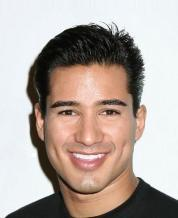

In [16]:
Image("img_align_celeba/000214.jpg") 

In [39]:
    
## Here we will get the 100 000 first images and put them in a variable 178*218*3
data_size = 25001
def get_data(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba_64/"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)
        return dataset
    
def get_data_normalized(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba_64/" + str(x).zfill(6) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)/255.0
        ## HSV
        #hsv = cv2.cvtColor(mpimg.imread(imgname), cv2.COLOR_BGR2HSV)
        #dataset.append(hsv)
        #dataset =  np.array(dataset)/255.
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
        
def get_batch(batch_size, dataset):
        indexes = np.random.randint(0, len(dataset), batch_size)
        data = dataset[indexes]
        return data

def sample_Z(batch_size=50, n=100):
        return np.random.uniform(-1., 1., size=[batch_size, n])

In [40]:

## HSV print image
#dat = get_data_normalized(5)

#dat = (dat * 255).astype(np.uint8)
#print(dat[2])
#im = cv2.cvtColor(dat[0], cv2.COLOR_HSV2BGR)
#cv2.imshow('image', im)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#plt.imshow(im)

In [41]:
def generator_mlp(Z, fc_sizes=[110,200,300], output_dim=64*64*3, reuse=False):
    
    with tf.variable_scope("Generator",reuse=reuse):
        fc1 = tf.layers.dense(Z, fc_sizes[0], activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(fc1, fc_sizes[1], activation=tf.nn.leaky_relu)
        fc3 = tf.layers.dense(fc2, fc_sizes[2], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(fc3, output_dim)
    return out


In [42]:
def discriminator_mlp(X, fc_sizes=[110,300,200], reuse=False):
    
    with tf.variable_scope("Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,fc_sizes[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,fc_sizes[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,fc_sizes[2],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h3,1)

    return out

In [43]:
X = tf.placeholder(tf.float32,[None,64*64*3])
Z = tf.placeholder(tf.float32,[None,60])

In [44]:
X_fake = generator_mlp(Z)
true_data_logits = discriminator_mlp(X)
fake_data_logits = discriminator_mlp(X_fake, reuse=True)

In [45]:
D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_data_logits,labels=tf.ones_like(true_data_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.zeros_like(fake_data_logits)))
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.ones_like(fake_data_logits)))


In [46]:
G_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Generator")
D_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Discriminator")

G_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(G_loss,var_list = G_variables) # G Train step
D_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(D_loss,var_list = D_variables) # D Train step


In [47]:
sess = tf.Session()
print("initializing variables...")
tf.global_variables_initializer().run(session=sess)
print("variable initialization done")


batch_size = 125

print("Loading data...")
dataset = get_data_normalized(50000)
print("Data loaded. Number of images: " + str(len(dataset)))

for i in range(5000):
    X_batch = get_batch(batch_size, dataset)
    X_batch = np.reshape(X_batch, (X_batch.shape[0], 64*64*3))
    Z_batch = sample_Z(batch_size, 60)
    _, Dloss = sess.run([D_step, D_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, Gloss = sess.run([G_step, G_loss], feed_dict={Z: Z_batch})

    print("N: %d\t D_loss: %.4f\t G_loss: %.4f"%(i,Dloss,Gloss))
Z_batch = sample_Z(1, 60)
X_batch = get_batch(1, dataset)
X_batch = np.reshape(X_batch, (X_batch.shape[0], 64*64*3))


# RGB
sess.run(X_fake, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

## HSV
#image = tf.reshape(G_sample, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch})
#image = (image * 255).astype(npint)
#im = cv2.cvtColor(dat[0], cv2.COLOR_HSV2BGR)
#plt.imshow(im)

initializing variables...
variable initialization done
Loading data...
Data loaded. Number of images: 50000
Data loaded. Number of images: 49999
N: 0	 D_loss: 1.3930	 G_loss: 0.6893
N: 1	 D_loss: 1.3318	 G_loss: 0.6888
N: 2	 D_loss: 1.2683	 G_loss: 0.6894
N: 3	 D_loss: 1.2126	 G_loss: 0.6889
N: 4	 D_loss: 1.1593	 G_loss: 0.6892
N: 5	 D_loss: 1.1200	 G_loss: 0.6896
N: 6	 D_loss: 1.0790	 G_loss: 0.6898
N: 7	 D_loss: 1.0523	 G_loss: 0.6899
N: 8	 D_loss: 1.0113	 G_loss: 0.6899
N: 9	 D_loss: 0.9890	 G_loss: 0.6904
N: 10	 D_loss: 0.9577	 G_loss: 0.6910
N: 11	 D_loss: 0.9359	 G_loss: 0.6914
N: 12	 D_loss: 0.9252	 G_loss: 0.6917
N: 13	 D_loss: 0.8978	 G_loss: 0.6921
N: 14	 D_loss: 0.8752	 G_loss: 0.6932
N: 15	 D_loss: 0.8644	 G_loss: 0.6936
N: 16	 D_loss: 0.8395	 G_loss: 0.6948
N: 17	 D_loss: 0.8250	 G_loss: 0.6958
N: 18	 D_loss: 0.8141	 G_loss: 0.6958
N: 19	 D_loss: 0.8023	 G_loss: 0.6971
N: 20	 D_loss: 0.7962	 G_loss: 0.6986
N: 21	 D_loss: 0.7881	 G_loss: 0.6996
N: 22	 D_loss: 0.7707	 G_loss

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


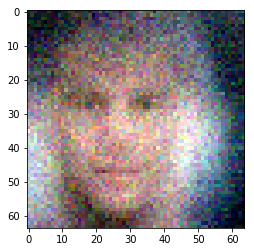

In [37]:
Z_batch = sample_Z(1, 60)
X_batch = get_batch(1, dataset)
X_batch = np.reshape(X_batch, (X_batch.shape[0], 64*64*3))
plt.imshow(tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

In [36]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

NameError: name 'G_sample' is not defined

In [33]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

ValueError: Dimension size must be evenly divisible by 12288 but is 116412 for 'Reshape_5' (op: 'Reshape') with input shapes: [?,12288], [3] and with input tensors computed as partial shapes: input[1] = [218,178,3].